In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from tqdm import tqdm
from arch import arch_model
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam



/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#Load the data
df=pd.read_csv('forex_data.csv', index_col='time', parse_dates=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

        Order      RMSE       MAE      MAPE
3   (0, 1, 0)  0.076178  0.065522  6.284825
16  (2, 1, 1)  0.076178  0.065522  6.284825
10  (1, 1, 1)  0.076178  0.065522  6.284825
4   (0, 1, 1)  0.076213  0.065561  6.288436
9   (1, 1, 0)  0.076216  0.065564  6.288764
5   (0, 1, 2)  0.076242  0.065592  6.291398
15  (2, 1, 0)  0.076243  0.065593  6.291477
11  (1, 1, 2)  0.076246  0.065596  6.291786
17  (2, 1, 2)  0.076248  0.065598  6.291916
12  (2, 0, 0)  0.091869  0.082519  7.882213
13  (2, 0, 1)  0.092033  0.082682  7.897664
7   (1, 0, 1)  0.092036  0.082687  7.898149
14  (2, 0, 2)  0.092211  0.082864  7.914823
8   (1, 0, 2)  0.092270  0.082924  7.920468
6   (1, 0, 0)  0.092338  0.082990  7.926720
0   (0, 0, 0)  0.102948  0.094973  9.050654
1   (0, 0, 1)  0.102987  0.094997  9.053049
2   (0, 0, 2)  0.103021  0.094989  9.052583
RMSE: 0.07617752470849193


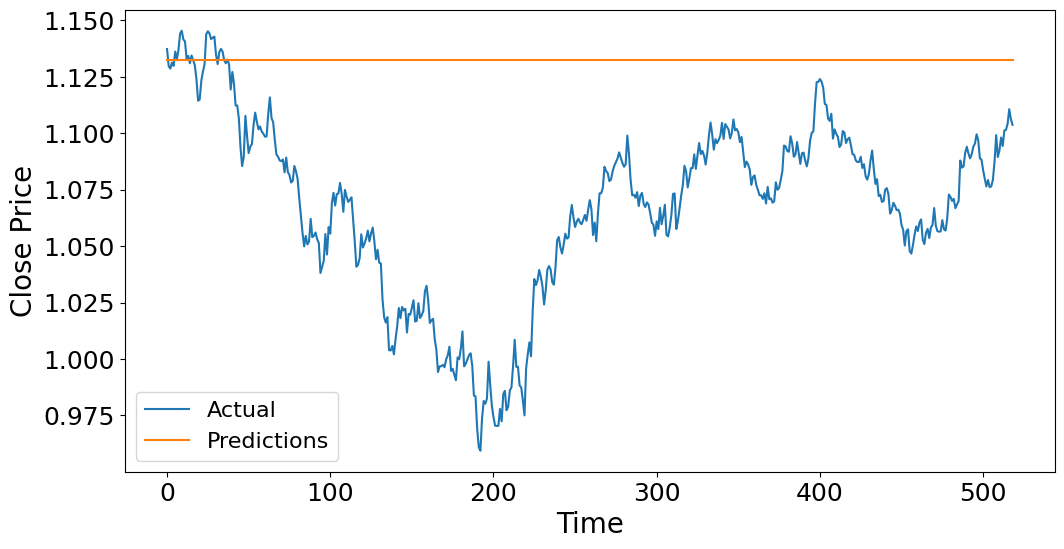

In [ ]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
trainset, testset = df[:train_size], df[train_size:]

train=trainset.close.values
test=testset.close.values
# grid search for ARIMA

# Define the function to evaluate an ARIMA model
def evaluate_arima_model(train, test, arima_order):
    try:
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast) * 100
        return rmse, mae, mape
    except Exception as e:
        return str(e), None, None

# Define a range of p, d, q values
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform the grid search
best_score, best_order = float("inf"), None
results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            rmse, mae, mape = evaluate_arima_model(train, test, order)
            if isinstance(rmse, float) and rmse < best_score:
                best_score, best_order = rmse, order
            results.append((order, rmse, mae, mape))

best_order, best_score
search_results_df = pd.DataFrame(results, columns=['Order', 'RMSE','MAE','MAPE'])
print(search_results_df.sort_values('RMSE'))

# Fit the ARIMA model with the best order on the entire training data
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit()

# Forecast the values for the test period
predictions = model_fit.forecast(steps=len(test))

# Calculate and print the RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print("RMSE:", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predictions')
#plt.title('Actual vs Predicted Close Prices (ARIMA)')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Close Price', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.rcParams['legend.fontsize'] = 16
plt.legend()
plt.show()


In [ ]:
# Set target variable
X = df['close'].values

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up parameters grid for ARIMA
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Store results
results = []

# Grid search over p, d, q
for p in tqdm(p_values):
    for d in d_values:
        for q in q_values:
            rmse_list = []
            mae_list = []
            mape_list = []
            try:
                for train_index, test_index in tscv.split(X):
                    train, test = X[train_index], X[test_index]
                    history = [x for x in train]
                    predictions = []
                    for t in range(len(test)):
                        model = ARIMA(history, order=(p,d,q))
                        model_fit = model.fit()
                        yhat = model_fit.forecast()[0]
                        predictions.append(yhat)
                        history.append(test[t])
                    # Calculate metrics
                    rmse = np.sqrt(mean_squared_error(test, predictions))
                    mae = mean_absolute_error(test, predictions)
                    mape = mean_absolute_percentage_error(test, predictions)*100
                    rmse_list.append(rmse)
                    mae_list.append(mae)
                    mape_list.append(mape)
                # Store results for this combination of p, d, q
                avg_rmse = np.mean(rmse_list)
                avg_mae = np.mean(mae_list)
                avg_mape = np.mean(mape_list)
                results.append((p, d, q, avg_rmse, avg_mae, avg_mape))
            except:
                continue

# Sort results by RMSE and get top 10
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'RMSE', 'MAE', 'MAPE'])
top_10_results = results_df.nsmallest(10, 'RMSE')
print("Top 10 Results based on RMSE:")
print(top_10_results)

# Use the best model from the top 10
best_params = top_10_results.iloc[0]
best_p, best_d, best_q = int(best_params['p']), int(best_params['d']), int(best_params['q'])

# Train on the entire training data and evaluate on test data
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = []

# Fit best model on the training data
for t in range(len(test)):
    model = ARIMA(history, order=(best_p,best_d,best_q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

# Calculate final metrics for the best model
final_rmse = np.sqrt(mean_squared_error(test, predictions))
final_mae = mean_absolute_error(test, predictions)
final_mape = mean_absolute_percentage_error(test, predictions)

print(f"Best Model: p={best_p}, d={best_d}, q={best_q}")
print(f"RMSE: {final_rmse}")
print(f"MAE: {final_mae}")
print(f"MAPE: {final_mape}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predictions')
plt.title(f'Actual vs Predicted Close Prices (ARIMA: p={best_p}, d={best_d}, q={best_q})')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conv